# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим 'распределенную' задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число 'переданной информации' от устройств к серверу). Сделайте вывод.

In [3]:
import my_optimization as opt
import numpy as np

In [4]:
#generating the problem setting
args = {}
args['n_workers'] = 10
args['L'] = 1000
args['mu'] = 1
args['d'] = 100
args['seed'] = 40

np.random.seed(args['seed'])
args['A_list'] = [opt.gen_A(args['d'], args['mu'] , args['L']) for i in range(args['n_workers'])]
args['b_list'] = [np.random.rand(args['d']) for i in range(args['n_workers'])]
x_0    = np.random.random_sample(args['d'])

def d_f_quad(x, args):
    res = 0
    for i in range(args['n_workers']):
        res += 1./2 * x.T @ args['A_list'][i] @ x - args['b'][i] @ x
    return res / (2 * args['n_workers'])

def d_f_quad_grad(x, args):
    grad_list = []
    for i in range(args['n_workers']):
         grad_list.append(args['A_list'][i] @ x - args['b_list'][i])
    return grad_list

In [3]:
FLOAT_BYTES = 4

def best_compressor_alg(title, n_iter, compression_coeff, c_param_list, y_lim = 1e-2, rand_k_activate = False, 
                        top_k_activate = False, diana_activate = False, ef_activate = False):

    def check_gamma(k, f, grad_f, x_k, x_true, args):
            return args['c']/(4 * args['L'])

    k_param = int(args['d'] * compression_coeff)

    x, y, labels = [], [], []
    def best_gamma(k, f, grad_f, x_k, x_true, args):
        return c_param_list[0]/(4 * args['L'])

    best_alg = opt.GradientOptimizer(
                                    d_f_quad, d_f_quad_grad, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = best_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate
                                    )
    best_points_arr, best_differences_arr, best_times_arr, best_acc_arr = best_alg.descent()
    best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]

    idx, best_idx = 0, 0
    for args['c'] in c_param_list:    
        check_alg = opt.GradientOptimizer(
                                    d_f_quad, d_f_quad_grad, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = check_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate
                                    )
        points_arr, differences_arr, times_arr, acc_arr = check_alg.descent()

        if (len(differences_arr) < len(best_differences_arr)): 
            best_alg = check_alg
            best_differences_arr = differences_arr
            best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
            best_idx = idx
            best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
        else:
             if differences_arr[-1] < best_differences_arr[-1]:
                best_alg = check_alg
                best_differences_arr = differences_arr
                best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
                best_idx = idx
                best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))

        information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(differences_arr))]
        x.append(information)
        y.append(differences_arr)
        labels.append(title + r"-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
        idx += 1

    best_idx_list = [best_idx]         
    return x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx_list

In [4]:
#for the b)
X_compare, Y_compare, Labels_compare = [], [], []

100%|██████████| 1000/1000 [00:01<00:00, 699.06it/s]


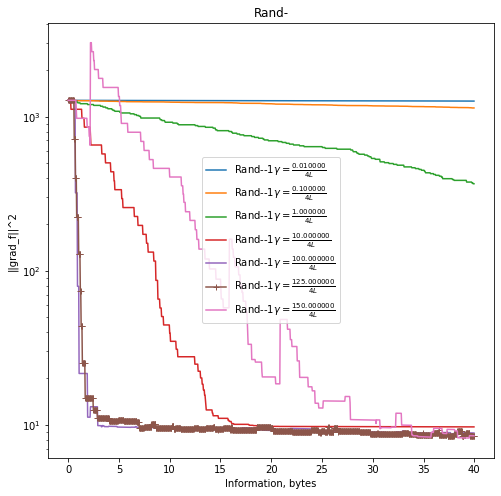

In [5]:
#LR fitting Rand1%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.01
c_param_list =  [0.01, 0.1, 1, 10, 100, 125, 150]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [6]:
X_compare.append(x[4])
Y_compare.append(y[4])
Labels_compare.append(labels[4])

### LR choice for Rand1%
- The function said that the best is when $c = 125$ (see the choice criteria 1), but I think the best is $c = 100$ because of stability

100%|██████████| 1000/1000 [00:01<00:00, 631.15it/s]


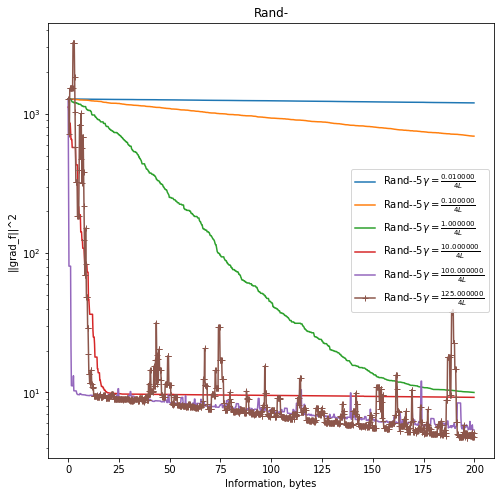

In [7]:
#LR fitting Rand5%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.05
c_param_list =  [0.01, 0.1, 1, 10, 100, 125]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title, 
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [8]:
X_compare.append(x[4])
Y_compare.append(y[4])
Labels_compare.append(labels[4])

### LR choice for Rand5%
- The function said that the best is when $c = 125$ (see the choice criteria 1), but I personally think the best is $c = 100$ because because it is fastest to converge

100%|██████████| 1000/1000 [00:01<00:00, 570.67it/s]


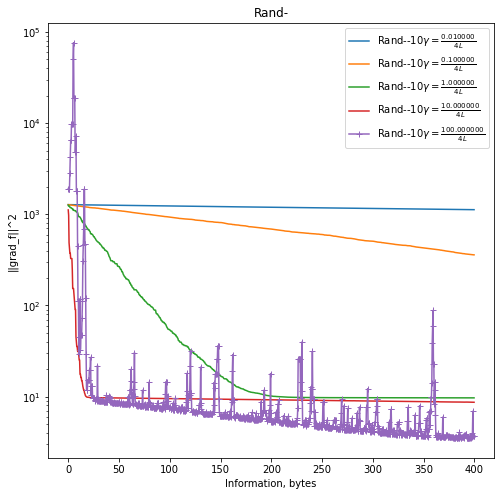

In [9]:
#LR fitting Rand10%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.1
c_param_list =  [0.01, 0.1, 1, 10, 100]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [10]:
X_compare.append(x[3])
Y_compare.append(y[3])
Labels_compare.append(labels[3])

### LR choice for Rand10%
- The function said that the best is when $c = 100$ (see the choice criteria 1), but I personally think the best is $c = 10$ because because it is stable than others, although not the fastest

100%|██████████| 1000/1000 [00:01<00:00, 557.20it/s]


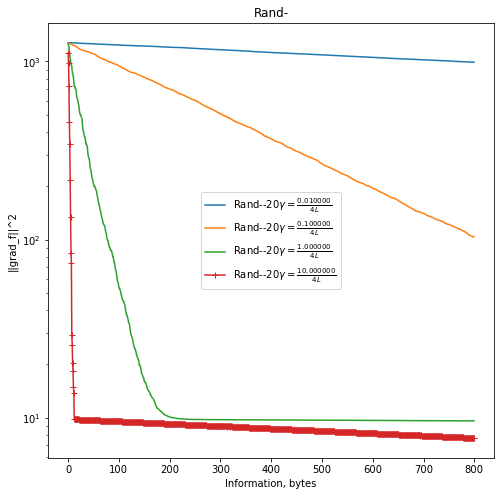

In [11]:
#LR fitting Rand20%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.2
c_param_list = [0.01, 0.1, 1, 10]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [12]:
X_compare.append(x[3])
Y_compare.append(y[3])
Labels_compare.append(labels[3])

### LR choice for Rand20%
- The function said that the best is when $c = 10$ (see the choice criteria 1) and I agree

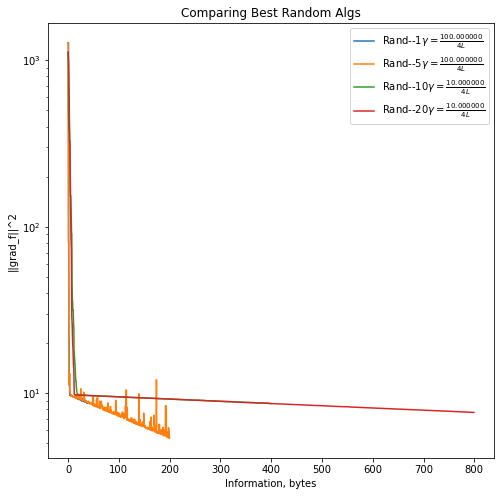

In [13]:
#Comparing them together
opt.plot_graphs(X_compare, Y_compare, x_label = "Information, bytes", lines_labels = Labels_compare, title = "Comparing Best Random Algs", logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = [])

### Conclusion
With the current theoretical learning rate the best result in terms of the speed and depth of convergence achieves Rand-5%, actually I don't have a clue why

The following statement I had for Rand-10%: it may be the best probably because the case is more independent (we have $d = 100, n = 10, k = 10$, so we choose the same coordinates less possibly and the overall coverage is pretty good)

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [14]:
X_compare, Y_compare, Labels_compare = [], [], []

100%|██████████| 2000/2000 [00:01<00:00, 1046.56it/s]


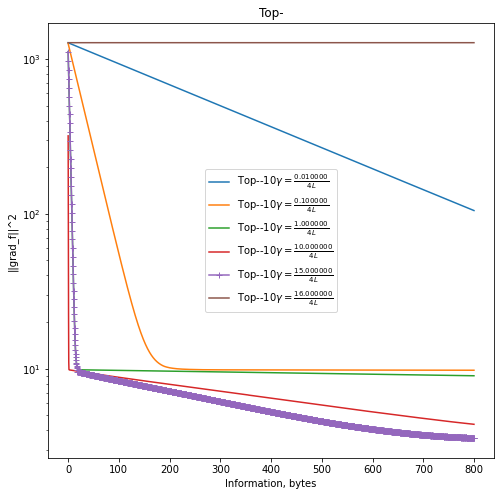

In [15]:
#LR fitting Top10%
title = "Top-"
n_iter = 2000
compression_coeff = 0.1
c_param_list = [0.01, 0.1, 1, 10, 15, 16] #16+ - divergence
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [16]:
X_compare.append(x[4])
Y_compare.append(y[4])
Labels_compare.append(labels[4])

### LR choice for Top10%
- The function said that the best is when $c = 15$ (see the choice criteria 1) and I agree with this statement

100%|██████████| 1000/1000 [00:01<00:00, 735.63it/s]


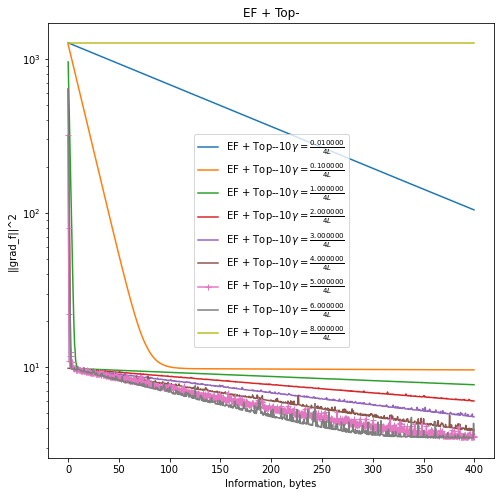

In [17]:
#LR fitting Top10%
title = "EF + Top-"
n_iter = 1000
compression_coeff = 0.1
c_param_list = [0.01, 0.1, 1, 2, 3, 4, 5, 6, 8] 
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [18]:
X_compare.append(x[6])
Y_compare.append(y[6])
Labels_compare.append(labels[6])

### LR choice for Top10% + EF
- The function said that the best is when $c = 5$ (see the choice criteria 1) and I agree with this statement (but based on the plot $c = 6$ also fits)

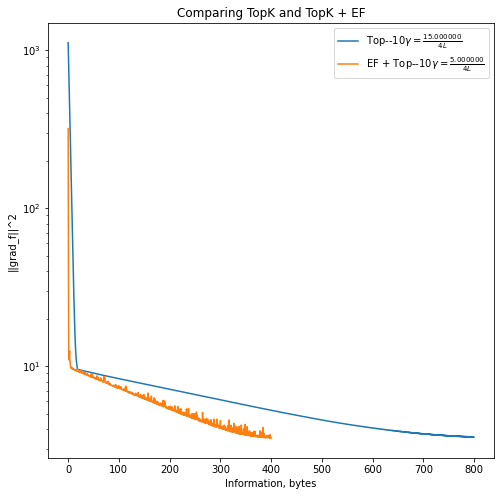

In [19]:
#Comparing them together
opt.plot_graphs(X_compare, Y_compare, x_label = "Information, bytes", lines_labels = Labels_compare, title = "Comparing TopK and TopK + EF", logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = [])

### Conclusion

So, the best error feedback mechanism helps to converge faster (and helps to basically converge)

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [5]:
#Data Preprocessing
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np

dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = y * 2 - 3

args = {}
args['n'], args['d'] = X.shape[0], X.shape[1] 
args['n_workers'] = 10

args['X_train'], args['X_test'], args['y_train'], args['y_test'] = train_test_split(X, y, test_size=0.2, random_state=True)
x_0 = np.zeros(args['d'])#np.random.sample(args['d'])
args['L'] = np.max(np.linalg.eigvals(1/(4*len(args['X_train'])) * args['X_train'].T @ args['X_train']))

def split_dataset(X_train, y_train, n):
    data = np.column_stack((X_train, y_train))
    np.random.shuffle(data)
    parts = np.array_split(data, n)
    X_parts = [part[:,:-1] for part in parts]
    y_parts = [part[:,-1].astype(int) for part in parts]
    return X_parts, y_parts

args['X_train_list'], args['y_train_list'] = split_dataset(args['X_train'], args['y_train'], args['n_workers'])

In [6]:
def d_logloss_mushrooms(w, args):
    ans = 0
    for i in range(len(args['X_train'])):
        ans += np.log(1 + np.exp(-(w @ args["X_train"][i]) * args["y_train"][i]))
    return ans / len(args["X_train"])

def d_logloss_grad_mushrooms (w, args):
    grad_list = []
    for j in range(args['n_workers']):
        n_samples = len(args['X_train_list'][j]) 
        
        grad_j = np.zeros(w.size) 

        for i in range(n_samples):
            grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
        grad_j /= n_samples
        grad_list.append(grad_j)
        
    return grad_list

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [3]:
X_crit, Y_crit, Labels_crit = [], [], []
X_acc, Y_acc, Labels_acc = [], [], []
specific_slice_num = 0

In [7]:
FLOAT_BYTES = 4

def best_compressor_alg_loss(loss, loss_gradient, func_title, n_iter, compression_coeff, c_param_list, y_lim = 1e-2, rand_k_activate = False, 
                        top_k_activate = False, diana_activate = False, ef_activate = False, ef21_activate = False, marina_activate = False, p_marina = 0.5):
    
    def log_acc(k, f, grad_f, x_k, x_true, args):
        corr_count = 0
        test_count = len(args['y_test'])
        for i in range(test_count):
            if args['X_test'][i].dot(x_k) * args['y_test'][i] > 0:
                corr_count += 1
        return corr_count / test_count

    def check_gamma(k, f, grad_f, x_k, x_true, args):
            return args['c']/(4 * args['L'])

    k_param = int(args['d'] * compression_coeff)

    x, y, labels, accs = [], [], [], []
    def best_gamma(k, f, grad_f, x_k, x_true, args):
        return c_param_list[0]/(4 * args['L'])

    best_alg = opt.GradientOptimizer(
                                    loss, loss_gradient, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = best_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate, acc_k = log_acc, 
                                    ef21_activate=ef21_activate, marina_activate=marina_activate, p_marina=p_marina
                                    )
    best_points_arr, best_differences_arr, best_times_arr, best_acc_arr = best_alg.descent()
    best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
    best_label = 'No best alg yet'
    idx, best_idx = 0, 0
    for args['c'] in c_param_list:    
        check_alg = opt.GradientOptimizer(
                                    loss, loss_gradient, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = check_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate, acc_k = log_acc, 
                                    ef21_activate=ef21_activate, marina_activate=marina_activate, p_marina=p_marina
                                    )
                                    
        points_arr, differences_arr, times_arr, acc_arr = check_alg.descent()

        if (len(differences_arr) < len(best_differences_arr)): 
            best_alg = check_alg
            best_differences_arr = differences_arr
            best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
            best_idx = idx
            best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
            best_acc_arr = acc_arr
        else:
             if differences_arr[-1] < best_differences_arr[-1]:
                best_alg = check_alg
                best_differences_arr = differences_arr
                best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
                best_idx = idx
                best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
                best_acc_arr = acc_arr

        information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(differences_arr))]
        x.append(information)
        y.append(differences_arr)
        labels.append(title + r"-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
        accs.append(acc_arr)
        idx += 1

    best_idx_list = [best_idx]         
    return x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx_list, accs, best_points_arr

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


[1.792812487932027, 1.7928073293085989, 1.7927964443337503, 1.7927888652255801, 1.7927817126122332, 1.7927737866503723, 1.7927668324732822, 1.792760282315908, 1.7927532594327003, 1.7927485006634183, 1.7927438657478942, 1.7927365836803988, 1.792731562220264, 1.7927232745260635, 1.7927168166542282, 1.7927098877601042, 1.7927044196240753, 1.7926959769816335, 1.7926895843886204, 1.7926828949767286, 1.792673782861131, 1.792667211488203, 1.7926616921400973, 1.7926541781124434, 1.7926465122510158, 1.7926399447211705, 1.7926329643698207, 1.792625924352283, 1.7926175419842567, 1.7926135877387723, 1.7926066851843643, 1.7925997353695493, 1.7925928856460696, 1.792585482790514, 1.7925790823816112, 1.7925721621006445, 1.792567043277217, 1.792560419766166, 1.792553102818845, 1.7925455684178737, 1.7925393452494596, 1.7925332186491023, 1.7925273032387454, 1.7925200280349043, 1.7925133881087354, 1.7925055729460542, 1.792497893003605, 1.7924909981956965, 1.7924841141663044, 1.7924789866589537, 1.79247445

100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


[1.7927514795771393, 1.79269134594322, 1.7926313157537224, 1.7925713473163236, 1.7924997799910762, 1.7924321668213323, 1.792369568692536, 1.7923130808758894, 1.7922452754947629, 1.7921807924361484, 1.7920956298480064, 1.7920521877043378, 1.7919831383231695, 1.7919167516595464, 1.7918407469545328, 1.7917774420514294, 1.7917167873774233, 1.791633566828788, 1.7915564206647954, 1.7914785204381902, 1.7913955980011522, 1.7913234417289812, 1.7912593802921495, 1.7911848601718607, 1.7911071886261132, 1.7910383049756098, 1.790966121330948, 1.7909082716104914, 1.7908531487063475, 1.790800865468094, 1.7907302911073177, 1.7906596199860936, 1.7905864043311672, 1.7905376654724485, 1.790476122637207, 1.7903936408704049, 1.7903256341807958, 1.7902517735578818, 1.7901827426992212, 1.7901187845622764, 1.7900513203763062, 1.7899984973740943, 1.7899118955748758, 1.789831637467131, 1.7897617957370677, 1.7897144422738218, 1.7896662629234148, 1.7895994388927583, 1.7895332438849572, 1.7894739453863686, 1.78939

100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


[1.7919937809717623, 1.7914194342519336, 1.7907403445787944, 1.7900702825838772, 1.7893904248993735, 1.7887422983868946, 1.7881499873914362, 1.7875085620721574, 1.7866075032246667, 1.7857751215328603, 1.7851732903994795, 1.7848045320002415, 1.7839655868246016, 1.7833087934830425, 1.7827830879659707, 1.7818815968551978, 1.7812233984737842, 1.7805383200136913, 1.7798060249538017, 1.7792754785889757, 1.7784051361281232, 1.7778163779427247, 1.7769903906371096, 1.7764503829183491, 1.775757134558441, 1.7750859915727573, 1.774377263443583, 1.7737870619096199, 1.7733191294915158, 1.772613665473511, 1.7718369437578332, 1.7710293454519466, 1.770512313426485, 1.7697141172791593, 1.7689935938424033, 1.7682339936572948, 1.7677216376973686, 1.766827203413906, 1.7663206241972425, 1.7657749662653153, 1.7650795941678001, 1.7643647023741285, 1.76380192701121, 1.7631703643894452, 1.7623974106144389, 1.761636633439958, 1.761050964961683, 1.7603753209320256, 1.760053239012614, 1.759418416559405, 1.75864657

100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


[1.787377220442351, 1.7801587710557274, 1.7728043585812785, 1.7677383385018608, 1.7632784195440925, 1.7582619091931155, 1.7505002657871158, 1.7433208052861855, 1.7345203986667599, 1.728041669621726, 1.7210386652348517, 1.7147053939111117, 1.708231129383183, 1.7010565539868705, 1.6929807625615056, 1.6860248206337918, 1.6811749860554912, 1.6742608205028848, 1.6677791924613798, 1.6633786417292808, 1.6589347718141567, 1.653358489977316, 1.649018325550624, 1.6427329223055953, 1.6392727260084836, 1.6313191904241926, 1.6259086816334507, 1.6212358926413986, 1.616029360530185, 1.6114200308787872, 1.6061461834166333, 1.5999375188057812, 1.5937526424202022, 1.5865474309361838, 1.5812422253558183, 1.5750158773410898, 1.571318604286517, 1.5668149500614044, 1.561692635142154, 1.5562794423180957, 1.5513177780888012, 1.5446417756785749, 1.5406541363276012, 1.5371133380789346, 1.532113255457169, 1.527346717384892, 1.524342591176042, 1.5181192032909903, 1.51361282265714, 1.5078291325873858, 1.5041517653

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


[1.7440945610446563, 1.6711176399097658, 1.6070223604665266, 1.5615076540726285, 1.4910646069129052, 1.4545678738300782, 1.4161093865760948, 1.372317656281996, 1.327183327919899, 1.2836748467023278, 1.2539371559122676, 1.224700591334395, 1.1882425515222095, 1.16543230231046, 1.1280546751360019, 1.0928456000921918, 1.0711699996695543, 1.051072155083672, 1.029864144515718, 1.0067123764531805, 0.9902237707768939, 0.9747464381770014, 0.9560006604700874, 0.9343353995514246, 0.9151345700152699, 0.8967856505416838, 0.8834554072712576, 0.8656936071364254, 0.8497723695600048, 0.835490456028378, 0.8153600479998718, 0.8031377310015768, 0.7925711572390679, 0.7785507963716007, 0.7627015186466771, 0.7545516194177195, 0.745396588367769, 0.7357543350606102, 0.7297009186896731, 0.7217025480637022, 0.7133234867766465, 0.7057042457303649, 0.6972621984944677, 0.6890137916314623, 0.6816316090367306, 0.6773183026761186, 0.6643748393792175, 0.6576919701661617, 0.6521148722183095, 0.6448023004722363, 0.636776

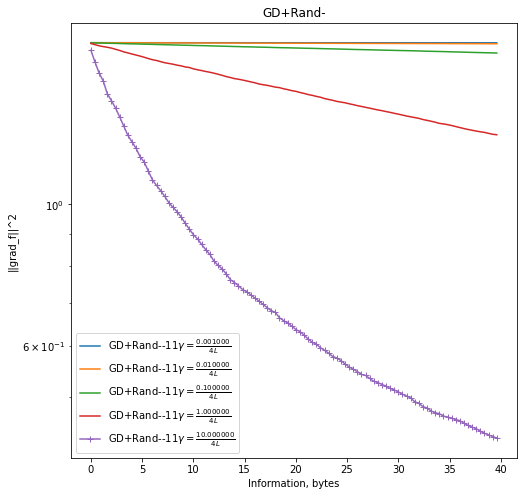

In [27]:
#LR fitting GD + Rand10%
title = "GD+Rand-"
n_iter = 100
compression_coeff = 0.1
c_param_list = [0.001, 0.01, 0.1, 1, 10, 50]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

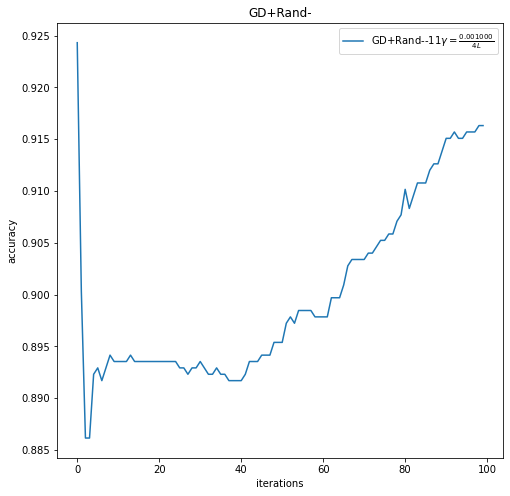

In [29]:
best_idx = 4 #or 5, need to see

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Rand10%
- The function said that the best is when $c = 10$ works okay (in the picture there is $c = 0.001$ but I can't change it now because it requires some time)

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


[1.7927776414682923, 1.7927360049173495, 1.7926943697993625, 1.7926527361142863, 1.7926111038620696, 1.7925694730426605, 1.7925278436560064, 1.7924862157020627, 1.792444589180778, 1.7924029640920989, 1.792361340435975, 1.792319718212361, 1.7922780974212007, 1.7922364780624485, 1.792194860136054, 1.7921532436419616, 1.7921116285801282, 1.792070014950498, 1.7920284027530262, 1.7919867919876586, 1.7919451826543444, 1.7919035747530347, 1.7918619682836854, 1.7918203632462366, 1.791778759640642, 1.7917371574668526, 1.7916955567248174, 1.7916539574144879, 1.791612359535811, 1.7915707630887383, 1.7915291680732208, 1.7914875744892038, 1.7914459823366442, 1.7914043916154865, 1.7913628023256827, 1.7913212144671826, 1.7912796280399355, 1.7912380430438941, 1.791196459479002, 1.7911548773452168, 1.791113296642484, 1.7910717173707553, 1.7910301395299788, 1.790988563120106, 1.7909469881410869, 1.790905414592869, 1.790863842475407, 1.7908222717886475, 1.790780702532541, 1.7907391347070378, 1.7906975683

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


[1.7924029170103701, 1.7919866978601953, 1.7915706219515128, 1.79115468923418, 1.790738899658115, 1.7903232531733047, 1.7899077497297926, 1.789492389277696, 1.7890771717671887, 1.7886620971485074, 1.7882471653719585, 1.7878323763879027, 1.7874177301467697, 1.7870032265990503, 1.7865888656953002, 1.7861746473861297, 1.785760571622219, 1.7853466383543055, 1.7849328475331923, 1.7845191991097404, 1.7841056930348715, 1.7836923292595719, 1.7832791077348875, 1.7828660284119195, 1.7824530912418421, 1.7820402961758777, 1.7816276431653155, 1.7812151321614982, 1.7808027631158376, 1.780390535979798, 1.779978450704904, 1.7795665072427445, 1.7791547055449595, 1.7787430455632516, 1.7783315272493858, 1.777920150555183, 1.7775089154325168, 1.7770978218333249, 1.7766868697096039, 1.776276059013406, 1.7758653896968406, 1.775454861712072, 1.77504447501133, 1.7746342295468913, 1.774224125271097, 1.7738141621363388, 1.773404340095074, 1.7729946590998082, 1.772585119103104, 1.7721757200575827, 1.771766461915

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


[1.7886573966449946, 1.7845098339952339, 1.7803765419268731, 1.7762574714804282, 1.77215257429423, 1.7680618025861157, 1.7639851091356211, 1.7599247844199364, 1.7558785278846234, 1.7518462853724284, 1.747828003445459, 1.7438236293651812, 1.7398331110729095, 1.7358563971707932, 1.731893436903301, 1.727944180139144, 1.7240161035797315, 1.7201015065728547, 1.7162003457569754, 1.712312578205007, 1.708438161410951, 1.704591824965343, 1.7007585597301351, 1.6969383270742358, 1.6931310886864923, 1.6893368065651522, 1.685555443007611, 1.6817869606004463, 1.6780313222097363, 1.6742938085582897, 1.6705690380440341, 1.6668569684128522, 1.6631575578222855, 1.659470764829871, 1.6557965483817718, 1.6521348678017138, 1.6484856827801855, 1.644848953363961, 1.6412246399458612, 1.6376127032548013, 1.6340131043461004, 1.6304258045920357, 1.6268507656726723, 1.6232879495669026, 1.6197373185437578, 1.6161988351539252, 1.6126724622215103, 1.609158162836018, 1.60565590034455, 1.6021656383441991, 1.59868734067

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


[1.7513766431597662, 1.7113870204436215, 1.67299445324697, 1.6359630488173211, 1.6001948063168816, 1.5656509474319351, 1.5325318746463423, 1.5006221268255777, 1.469901183032088, 1.4402111016656163, 1.41157427448292, 1.3842351011796585, 1.3578011464271231, 1.332354490811695, 1.3077684375066254, 1.2839643055510896, 1.261081175815374, 1.238902663893182, 1.2174448099425235, 1.1968178335191637, 1.1768180649731124, 1.1576113375751933, 1.1389703020619397, 1.1208756429386837, 1.1033571276145626, 1.0864937332260107, 1.070106410465417, 1.0543457281826947, 1.0390139583208446, 1.0241811875659055, 1.00976996615949, 0.9958541312317005, 0.982379092012023, 0.9692485523291436, 0.9565127845468414, 0.9441651116095656, 0.9321919822177804, 0.9205746712039315, 0.9092320544612228, 0.8982116348162928, 0.8874480739338072, 0.876968736209032, 0.8667279434657708, 0.8567642349836528, 0.8470944732339754, 0.8376363088821643, 0.8283838734066777, 0.8193315672009835, 0.8104944546739746, 0.8019577022215189, 0.7936103794

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


[1.4000763126183324, 1.146729318650135, 0.9767910347562109, 0.8579889914322507, 0.766334962232629, 0.695736701044805, 0.6403334375263228, 0.5938262115878878, 0.5545325893234585, 0.5218965736962105, 0.4931497270549404, 0.4680844640253239, 0.4466323564952835, 0.42775502229638396, 0.41096048484227865, 0.39580883071120815, 0.3821807554634564, 0.3698554272275389, 0.3588200022549943, 0.34854879242677217, 0.3389542580340926, 0.3300467712958812, 0.3216352675263148, 0.3137173337766864, 0.30624864921117056, 0.2992053071733417, 0.29255605535616, 0.2863133085373507, 0.2803611871013032, 0.27468047161417436, 0.2692781508230797, 0.2641135112110303, 0.25919246227750325, 0.25452683703475054, 0.2500715449172459, 0.24580050993722494, 0.24169733943393396, 0.23776668547394328, 0.2339912081369108, 0.23038986495338343, 0.22691073280541652, 0.2235704320887465, 0.22033484584660626, 0.21720540536327468, 0.2142052770742071, 0.21134755710657505, 0.20857438152875873, 0.20589751439436638, 0.2033088717844926, 0.2007

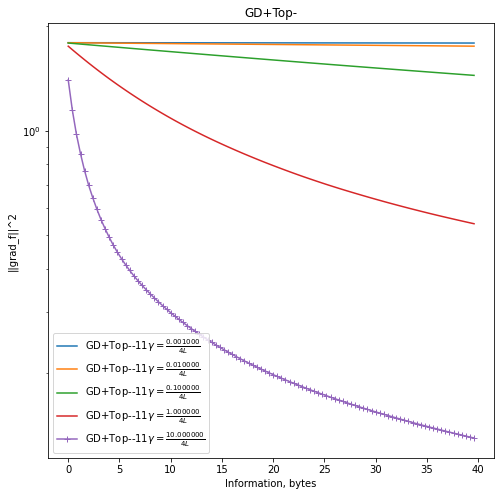

In [30]:
#LR fitting GD + Top-10%
title = "GD+Top-"
n_iter = 100
compression_coeff = 0.1
c_param_list = [0.001, 0.01, 0.1, 1, 10, 50]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

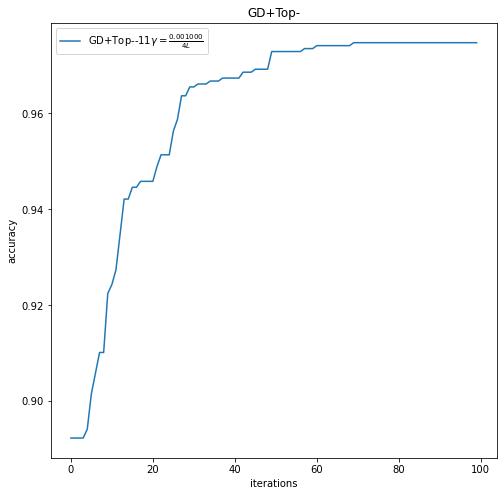

In [31]:
best_idx = 4 #or 5, need to see

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Top10%
- The function said that the best is when $c = 10$ and I think it's okay

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:117: ComplexWarning: Casting complex values to real discards the imaginary part
  compressed_grad[rand_indices] = grad[rand_indices]
c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:151: ComplexWarning: Casting complex values to real discards the imaginary part
  errors_list[i] = errors_list[i] + gamma * grad_list[i] - displaced_grad_list[i]
100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


[1.7928078599116495, 1.792786448703114, 1.7927372447603915, 1.7926861925007238, 1.7926610597662755, 1.7925743563101983, 1.7924908018127057, 1.7923865996860144, 1.7923102755495093, 1.7922404350972752, 1.7921631797692046, 1.792102060290769, 1.791989256282691, 1.7918591018519383, 1.7917581353730871, 1.7916503248329216, 1.7915167144040567, 1.7913678576298682, 1.791259745348537, 1.7911884779401852, 1.7910280501685085, 1.7908620916662583, 1.7907125491549454, 1.790631572155669, 1.7905430274323253, 1.7903793162515809, 1.7902710072359147, 1.7901593884692202, 1.7899933752938277, 1.7898784150071314, 1.7897772420871527, 1.7896488128239372, 1.7894814907875871, 1.7893711729029802, 1.7892127755455423, 1.7890603884351515, 1.7889538218257452, 1.7888576743115492, 1.788699722833263, 1.7885911657541345, 1.788429514018631, 1.7883460232190471, 1.7882045327820697, 1.7881075829992117, 1.7879548402110677, 1.7878355869124611, 1.7877518508249663, 1.787621348345822, 1.787458401458562, 1.7873508935284872, 1.787194

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


[1.7927017184690126, 1.7924213713084964, 1.792095070004394, 1.791501706601083, 1.7909306560254377, 1.7902887003826602, 1.789459090144806, 1.7885023430676317, 1.7879749987279583, 1.7874947951236868, 1.786249302158747, 1.7854734912949572, 1.7845212033240478, 1.7831538320057394, 1.7819284723601783, 1.7808596252743558, 1.779429234377089, 1.7781457270076972, 1.7763521722743818, 1.7754611022204954, 1.7743121220701745, 1.7732244171319922, 1.7726550523884759, 1.7718102131759965, 1.770473954677907, 1.7691670234489287, 1.7676914319253847, 1.7670354581541634, 1.7661570630496268, 1.7653826139818762, 1.764185201619002, 1.7630856011309362, 1.7617386446152417, 1.760395948807041, 1.759060264500598, 1.757551032537058, 1.7559304168364662, 1.7545628580484103, 1.7532912270705385, 1.7525348681739394, 1.7507716968032774, 1.7497315092280346, 1.7486470985489662, 1.7473219191264795, 1.7465530685922104, 1.7447115102497972, 1.742834575616693, 1.7411996227191116, 1.7401045608329073, 1.739116976440706, 1.736904382

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


[1.7920810075776612, 1.7893491998679174, 1.7851989665493233, 1.7806921798342394, 1.7761967954269329, 1.770948251569857, 1.7640634357779037, 1.7594284440432082, 1.752114233155956, 1.7441247348579387, 1.7381638758510072, 1.7270765202443086, 1.7163521400850585, 1.7062012619922589, 1.6989846726974107, 1.6819864556869988, 1.6729219207246409, 1.6652441460654206, 1.6545042876056237, 1.642156094604036, 1.635055382620282, 1.6240694208979045, 1.6143274737653979, 1.6039084838678814, 1.5937710673521226, 1.5791928859436029, 1.5644609740293982, 1.5536755377431206, 1.54512452591826, 1.5301770500851681, 1.5177160356191, 1.509255913645219, 1.493829319049828, 1.4886258841299427, 1.4808600848514295, 1.4739032912119894, 1.462564688883771, 1.4479944414388248, 1.4394768698427303, 1.430407129548756, 1.4223323304675124, 1.417448009456145, 1.405122481483078, 1.3955772797283403, 1.3892245428953474, 1.37530943666989, 1.3630702246672808, 1.356831243325702, 1.3451138588046967, 1.3390163087448184, 1.326987954610173

100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


[1.7749583987035669, 1.7587137357698601, 1.731123091730066, 1.690220948099171, 1.647150722823125, 1.5654500008666121, 1.5048288591729981, 1.4439055148528392, 1.3695697462177323, 1.3028367481581506, 1.2528684442595261, 1.2009322177806168, 1.1522213936148447, 1.0914332861530045, 1.0308814539377134, 0.9809839206636667, 0.9446115397840679, 0.8876625846660309, 0.8436440396870625, 0.8333648692925127, 0.8096541199022148, 0.7549280256711994, 0.7128427283239754, 0.6923086321354965, 0.6669224332462264, 0.6418614182293447, 0.6345494796776057, 0.6166029927682748, 0.5985750842554061, 0.5854669975114952, 0.5795377029339656, 0.5639696161605895, 0.5564233341615631, 0.5500922379794481, 0.5314598153850558, 0.5193539532365566, 0.5174422962849566, 0.5068570287518637, 0.4954731327835448, 0.49091221012631703, 0.4813944227219837, 0.47392448517651947, 0.4674816698062217, 0.4661849303019505, 0.4700748385071239, 0.45728219616833504, 0.45699342406468607, 0.4318894714385238, 0.4259807495390336, 0.4190262994037194

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


[1.636529335560838, 1.46552009480666, 1.1213964569020496, 0.8991431616813949, 1.264786933146552, 1.210329872754807, 0.8165641327073633, 0.5355801433546868, 0.5331190344410459, 0.5162473259948035, 0.44734078096656876, 0.4167399530844476, 0.31809033767892614, 0.3771026011924997, 0.2882306186580048, 0.3207011364309928, 0.3683871739847159, 0.3337072361952769, 0.2858720492455412, 0.2282883617993245, 0.25566748942393197, 0.23764558427989793, 0.23154602465862542, 0.20071733234376796, 0.2292652704308795, 0.20420576804086743, 0.15449600062657298, 0.12265283032738294, 0.18192519830828113, 0.1975406437035849, 0.22703786366343418, 0.20112455800651444, 0.1966019020820809, 0.25029991081301367, 0.2127133087739007, 0.17770183923386487, 0.10563740954841948, 0.11790608528471928, 0.1746226268562882, 0.20064834754629088, 0.21958377352604821, 0.3107324715272867, 0.2671448001413994, 0.2139799302462619, 0.13478113104473952, 0.09308341673961322, 0.08330773916272524, 0.09737968635346267, 0.08479426338298887, 0

100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


[1.2682156565001568, 0.7433504085355924, 2.2314007868567045, 0.6653426267852381, 0.9025215163149974, 0.48190771512007924, 0.44332418826726805, 0.7926695940358585, 1.3695287724273357, 0.2742268658625656, 1.0163196459427792, 0.915915827115036, 0.583383220154281, 0.3821035000735533, 0.12604818154383052, 0.16627514446837469, 1.133431796607492, 0.4255362544878657, 0.4582181019460734, 0.2278465429644347, 0.10394943428077393, 0.12394322423581364, 0.16989269503996024, 0.14121243792146485, 0.17755981684638156, 0.15650722714314833, 0.13074040076037755, 0.08239709425701827, 0.10403588416339404, 0.22446222578760486, 0.265006675471668, 0.2068422689973287, 0.19404972365049317, 0.06300718402208137, 0.0712099563372119, 0.07714829947310857, 0.09667679406889951, 0.19651260942069, 0.18083222917165093, 0.15631588747107236, 0.14036195215002573, 0.11116098100343604, 0.07657501092258162, 0.05840763734912166, 0.0518483260995282, 0.1326425693293974, 0.15527676341242277, 0.17089244643918303, 0.22099790697537378

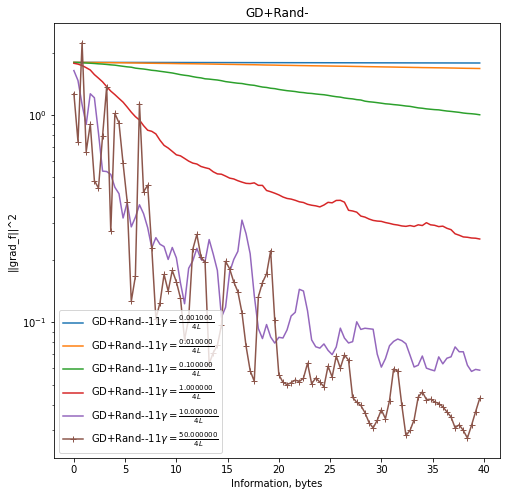

In [32]:
#LR fitting GD + Rand-10% + EF
title = "GD+EF+Rand-"
n_iter = 100
compression_coeff = 0.1
c_param_list = [0.001, 0.01, 0.1, 1, 10, 50, 100]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

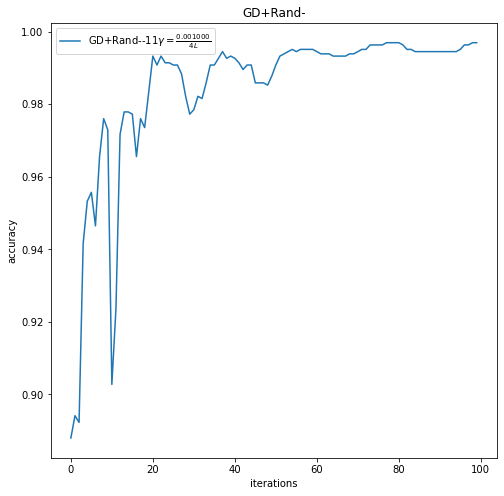

In [34]:
best_idx = 4 #or 5, need to see

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Rand10% + EF
- Here I agree with the function again ($c = 50$), although the descent is not smooth

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  compressed_grad[top_indices] = grad[top_indices]
c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:151: ComplexWarning: Casting complex values to real discards the imaginary part
  errors_list[i] = errors_list[i] + gamma * grad_list[i] - displaced_grad_list[i]
100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


[1.7927360038709197, 1.7926496015585727, 1.7925191565700902, 1.7924185650452336, 1.7922908811627316, 1.792163011829105, 1.7920455116108334, 1.79191739537036, 1.7918050336348734, 1.7916438341617, 1.7915434199722118, 1.7913970387693514, 1.7912643934133166, 1.7911290265591748, 1.7910188139130807, 1.790862670156405, 1.7907200719254597, 1.790594734609012, 1.7904740158512713, 1.7903235548987817, 1.7902005292419576, 1.7900528838732215, 1.7899351657135818, 1.7897920410333439, 1.7896626553772226, 1.7895158170807373, 1.7894070860951365, 1.7892591100397666, 1.7891209895147546, 1.7889936304849379, 1.7888592815787974, 1.788697682141631, 1.788580815843896, 1.7884373429581182, 1.78831719580032, 1.7881742725518541, 1.788045693483585, 1.7879036519487392, 1.787787495368307, 1.7876394810640037, 1.787516828456607, 1.7873705122407433, 1.7872517810048476, 1.7870975820092123, 1.786977410396482, 1.7868306731952566, 1.7867128995943165, 1.7865817522257317, 1.7864358647999345, 1.7863015239103395, 1.7861897870649

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


[1.7919865932377637, 1.7911231111533175, 1.7898207383105884, 1.7888163724141288, 1.7875446819424246, 1.7862698631086404, 1.7851006849067668, 1.783826256892465, 1.7827108556478197, 1.7811094176289441, 1.780116186069977, 1.7786655597936893, 1.777358268964144, 1.776029623938952, 1.774930932639964, 1.773386316972754, 1.7720529152853128, 1.770746878535528, 1.7695569654305756, 1.7681158001517376, 1.7668759342570923, 1.7654001401288744, 1.764311160444289, 1.7628668756850696, 1.7616096004261554, 1.7602100946021058, 1.759117259843202, 1.757650643063911, 1.756374355237329, 1.7551477317994666, 1.7538079051656512, 1.7522804195132775, 1.7511571650709221, 1.7497638632507078, 1.7485580768699533, 1.7472235456486056, 1.745916436190321, 1.7446340323145715, 1.743495900809276, 1.7420308120650319, 1.7407807906447539, 1.7395025636009371, 1.7383685512072133, 1.7368611960775218, 1.73571033339185, 1.7344100002504317, 1.733156265084814, 1.7318760837482265, 1.730651783649797, 1.7292286775817296, 1.72820865795159

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


[1.7844993921141565, 1.775918419653414, 1.7630989107656472, 1.753208909817647, 1.7411778430950418, 1.7285834818003318, 1.7176644734040294, 1.705411088985146, 1.6953225538070713, 1.6799210690112814, 1.6714890722623994, 1.6583101124386654, 1.646684166777525, 1.6347281633556234, 1.6241764427360583, 1.6110241087962391, 1.6006290855506573, 1.5885451100964525, 1.5784688210812272, 1.5668708805238303, 1.5557554726330551, 1.5441162141453766, 1.5355720152799688, 1.5246137549249523, 1.51366200127024, 1.5028367335782455, 1.494283030365025, 1.4823286729628529, 1.4725378598611947, 1.4631310448654913, 1.453861815631071, 1.4429066681049834, 1.434659557720059, 1.4245550129034072, 1.4163567457705872, 1.4060229026967344, 1.397452134808476, 1.3880249688197204, 1.381101653169235, 1.3708269923282599, 1.3621216165671233, 1.3539841948041336, 1.346293384497977, 1.3364838963107533, 1.3291840671084063, 1.3204155051777136, 1.3136822136972526, 1.30517754316664, 1.2969462284755422, 1.2880779980762436, 1.28190507059

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


[1.7103357980027558, 1.6316735525290702, 1.5172395778308327, 1.4403986106061388, 1.3563989214101373, 1.26006349617816, 1.2092597738996607, 1.136892542837732, 1.080087089107916, 1.027042279951036, 0.9819465323661648, 0.9340671426552303, 0.8957658444741049, 0.8547196854548585, 0.8298316585288299, 0.794790320151193, 0.7747543463826628, 0.7451393025152592, 0.7251419273613885, 0.7010130266415089, 0.6857386472456518, 0.6648092174192967, 0.649313804603373, 0.6329610930632253, 0.6208496269208829, 0.6037883455782649, 0.5947307081833418, 0.5793156408720415, 0.5705145082837358, 0.5579039374122088, 0.5483110540041849, 0.5364517439856085, 0.5289537460049938, 0.5165882065399434, 0.510428272685928, 0.5000746091832635, 0.49361177758520874, 0.48421369808493614, 0.478547395093958, 0.4693616173030892, 0.4647607514053886, 0.45575811835885244, 0.4509032278791011, 0.44330855721468104, 0.43848979340216276, 0.4307060248639366, 0.42646662868007035, 0.4201747155244159, 0.41622639714681997, 0.40924655089543804, 

100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


[1.0954296327888413, 0.8186972792989349, 0.771410762143726, 0.5612592744615639, 0.4046657838331005, 0.3681058014377087, 0.3357200982346976, 0.3040410080996049, 0.2816186689059195, 0.263536325143643, 0.26620242400343974, 0.23484357437240905, 0.21866365387581052, 0.20658417291481607, 0.2543747317096577, 0.18729996765963886, 0.17352369264414913, 0.16639320138033864, 0.16677349183339357, 0.15102514316888646, 0.14997042154542906, 0.14497271947904855, 0.1386723890369801, 0.1350678520127603, 0.13391844875465403, 0.1253590225011179, 0.1214909990199664, 0.12058181685900758, 0.12380067930535249, 0.1131380510517839, 0.1103040983666047, 0.10863775885718432, 0.11501911129463759, 0.10536938382645206, 0.10308643824786567, 0.09971292723480457, 0.10254240712315571, 0.09714293874183037, 0.09512843235732119, 0.09329925040876075, 0.09522724329462047, 0.08936001524123889, 0.09108286696491785, 0.09092952764217137, 0.08853007792155132, 0.08473707366568212, 0.08287092979596392, 0.08354378236624642, 0.08041360

  4%|▍         | 4/100 [00:03<01:16,  1.26it/s]<ipython-input-21-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][

[8.92950671757252, 5.655082542940563, 5.652391706336305, 474.87668525317645, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


[260.35866435350215, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


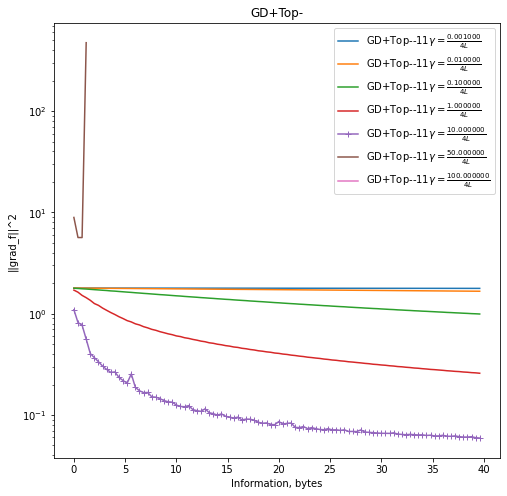

In [35]:
#LR fitting GD + Top-10% + EF
title = "GD + EF + Top"
n_iter = 100
compression_coeff = 0.1
c_param_list = [0.001, 0.01, 0.1, 1, 10, 50, 100]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

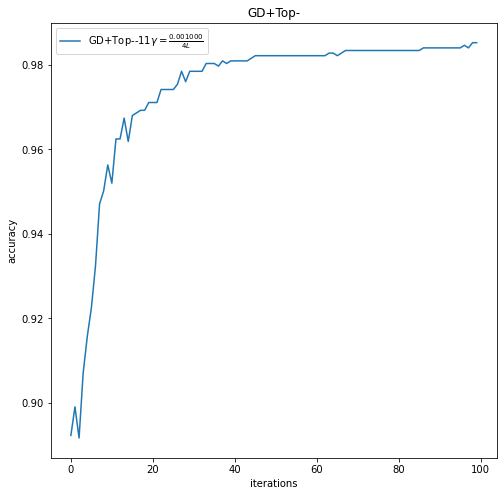

In [37]:
best_idx = 4 #or 5, need to see

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Top10 + EF%
- The function said that the best is when $c = 10$ (see the choice criteria 1) and I agree with this statement

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


[1.7926844547573277, 1.7925496366030822, 1.7924148263080573, 1.7922800249210404, 1.7921452334323686, 1.7920104507297863, 1.7918756787826629, 1.791740918472979, 1.791606169245771, 1.7914714320205807, 1.7913367061321572, 1.7912019947095017, 1.7910672972075783, 1.7909326114925663, 1.7907979397046987, 1.790663284419835, 1.7905286433831968, 1.7903940136608423, 1.790259402259818, 1.790124808949911, 1.7899902285763603, 1.789855663927484, 1.7897211216644122, 1.78958659213109, 1.7894520796327924, 1.7893175837105728, 1.7891831025853477, 1.7890486392910112, 1.7889141884149804, 1.7887797559560938, 1.788645336892094, 1.788510929618765, 1.7883765365323274, 1.78824216100608, 1.788107802658759, 1.787973462619979, 1.7878391385252408, 1.7877048303190932, 1.7875705390459584, 1.7874362616185935, 1.7873020007202756, 1.7871677665212384, 1.7870335507989508, 1.7868993470575798, 1.7867651599840295, 1.7866309921481864, 1.7864968389102964, 1.786362708763921, 1.7862285936676874, 1.7860945002152775, 1.785960424596

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


[1.791471279233225, 1.790123891183808, 1.7887772719651764, 1.787431487207128, 1.7860867288928914, 1.7847429926619718, 1.7834003329859045, 1.7820589667721696, 1.7807186895171703, 1.7793796076287534, 1.7780418822672681, 1.7767054648866314, 1.775370201147632, 1.7740364206373043, 1.7727042407943543, 1.7713735826760864, 1.7700442124082485, 1.7687162307579682, 1.7673896747259996, 1.7660646044855126, 1.7647412780075529, 1.7634196220388387, 1.7620993996477814, 1.760780650469046, 1.759463272414405, 1.7581476098517106, 1.7568337122383035, 1.7555214983686462, 1.7542102337373082, 1.7529005534341997, 1.7515925056285582, 1.7502856598035463, 1.7489802297477157, 1.7476764451334819, 1.7463747575529822, 1.7450749074898413, 1.7437763371670247, 1.7424795430990287, 1.7411842995682276, 1.7398901673863678, 1.7385978290166635, 1.7373070382769475, 1.7360183232535031, 1.7347310817522699, 1.7334453894713098, 1.732161505490302, 1.7308787484749508, 1.729597526849144, 1.7283180421983617, 1.7270399634215763, 1.72576

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


[1.7793638548875963, 1.7659750499380258, 1.7526579844942178, 1.7394241996133852, 1.7262852505177055, 1.713245471087516, 1.7003013381368806, 1.6874698628506126, 1.674720031464808, 1.6620679410728834, 1.6495141380602882, 1.6370662910851481, 1.6247097370299683, 1.6124647694431953, 1.6003735563222867, 1.5884000096801403, 1.5765411393894722, 1.5647975534306906, 1.5532074572580374, 1.5417354332701194, 1.5303941300250072, 1.519174199480753, 1.5080596943428297, 1.4970882351590287, 1.4862230231784463, 1.4754519559058676, 1.4648153670752808, 1.4543339944066322, 1.4439856474808623, 1.4337651183669493, 1.4236695114948097, 1.4137210512349743, 1.4038822964687914, 1.3941989172698734, 1.3846200358606056, 1.3752002246486683, 1.3658883057583444, 1.3566953523614, 1.347605470391541, 1.338624700051081, 1.3297293046582637, 1.3209418184853914, 1.3122856016417612, 1.3037443573868819, 1.2953127512491693, 1.2870444687406462, 1.2788968237832241, 1.2708319529929135, 1.2628684164187893, 1.2549932329467162, 1.24719

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


[1.6606462441000438, 1.534680589979018, 1.4157235403671926, 1.3047607446762897, 1.2032277009529078, 1.1129543345316848, 1.0343026165874523, 0.9686649059232095, 0.9147469209288143, 0.872577599149806, 0.8422181082947608, 0.8162434487291627, 0.7923975350437398, 0.7697051457864253, 0.746042474875455, 0.7223669948956458, 0.6944948618401694, 0.6645817633793574, 0.6363743725753542, 0.6117099609920581, 0.5891942268262754, 0.5688475051376642, 0.5524201411573553, 0.5379250952688918, 0.5249785674966742, 0.5133070615145197, 0.5026449557080889, 0.49276552453521427, 0.48331724526422276, 0.4747442574646335, 0.46686797110399725, 0.45959311183032403, 0.45252169382490165, 0.4455011870084736, 0.4386028968795368, 0.4318010889942603, 0.4253859500007306, 0.4194805317210571, 0.41378317423507327, 0.408326105064742, 0.40282291613978194, 0.39740982139131187, 0.39195084072906367, 0.38662877435568316, 0.38137025002840264, 0.37629706191249157, 0.37142787591563414, 0.3667566252422359, 0.36236307173419174, 0.3582120

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


[0.9046868581334304, 1.9302820125141649, 3.0127322526758347, 3.128396752146161, 2.2529682695887954, 0.8555683144948014, 0.46903543239036066, 0.8592096404138992, 1.1574425952709015, 1.2913913845298435, 1.3508757887101803, 1.231043149473801, 1.0846138268023826, 0.8482565112277839, 0.6035406052521443, 0.37704859551203096, 0.22445593819048026, 0.4285084761266987, 0.6395250428977365, 0.8296410668163439, 0.9162256053166334, 0.8644672675961417, 0.7721429129506537, 0.6304942687167111, 0.4328367923650137, 0.3108212760578069, 0.19253929176106235, 0.16835663197277076, 0.2022761097073423, 0.23390893385942818, 0.24570526941361667, 0.2546800482309091, 0.2547586712090538, 0.25060706188841275, 0.24661904512462784, 0.2402211422683061, 0.21262331506785792, 0.18136436399748035, 0.1508753714790714, 0.14074277860473994, 0.1651879037927017, 0.19119838002019024, 0.22728192936312824, 0.25472721391699493, 0.2672298510471005, 0.2670600349144836, 0.23771063699525247, 0.20509754920343026, 0.1697680717824029, 0.14

 15%|█▌        | 15/100 [00:11<01:06,  1.27it/s]<ipython-input-21-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list']

[25.303173126373817, 1.275546029483599, 3.3131497667576366, 3.171511362934888, 1.9672880790191647, 5.264137112428952, 106.53421924848801, 3.8652616213766975, 4.954826357239318, 5.029304712245763, 5.093512465398129, 5.101326089754457, 5.059129391910304, 4.766588648833712, 4741.867065219558, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


[1435.8386845706248, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


[125960.9360842207, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


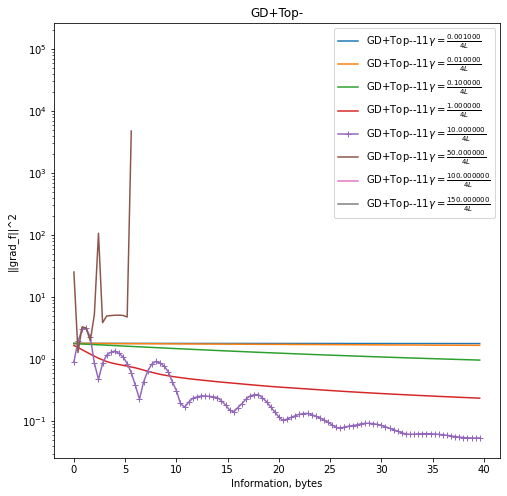

In [38]:
#LR fitting DIANA + Rand10%
title = "DIANA + Rand"
n_iter = 100
compression_coeff = 0.1
c_param_list = [0.001, 0.01, 0.1, 1, 10, 50, 100, 150]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = True, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

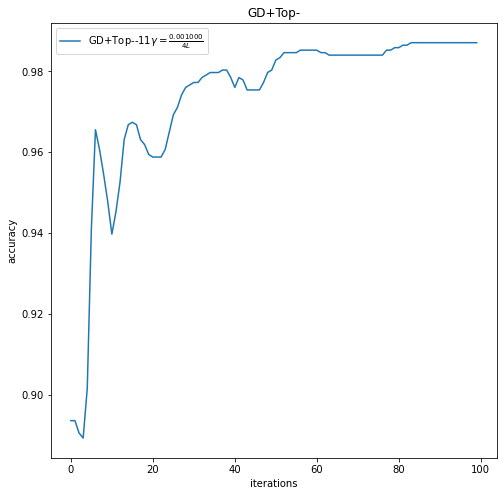

In [39]:
best_idx = 4 #or 5, need to see

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for DIANA + Rand10%
- The function said that the best is when $c = 10$ (see the choice criteria 1) but I'll probably choose something between $c = 1$ and $c = 10$, because it is a bit unstable at the start, although it is more stable at the end

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


[1.7793638548875963, 1.7660344391054505, 1.7528268539742562, 1.7397704162912735, 1.7268582656530893, 1.71409348379942, 1.701472682086932, 1.688991119034455, 1.676659894674339, 1.6644623871139508, 1.652408739071037, 1.6404880154114971, 1.6287054953651081, 1.6170472821254673, 1.6055338088300375, 1.5941484201937401, 1.5828923080441393, 1.5717657763995152, 1.5607644831526375, 1.5498897582134705, 1.5391478319260519, 1.5285158829414323, 1.518012670014036, 1.5076299704922886, 1.4973718598517627, 1.487230570391819, 1.4772125251583705, 1.467304328473152, 1.4575145997038228, 1.447834409975027, 1.4382696233335064, 1.428814280732461, 1.4194701289016487, 1.4102336350895166, 1.4011089580905272, 1.392081798886555, 1.3831671235956071, 1.3743516380284346, 1.3656406347778438, 1.357027168601958, 1.348521194701119, 1.340109112743532, 1.3318029864942624, 1.3235833016262453, 1.315470073014005, 1.3074450772385386, 1.299516221715352, 1.2916756979069106, 1.2839293298679009, 1.2762754172750983, 1.26871202817802

100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


[1.6606462441000438, 1.5401280891993814, 1.4299109365011267, 1.332294223352755, 1.2454142863868543, 1.1688614373681814, 1.1020103461995137, 1.0423807563997098, 0.9898512258938236, 0.942881866110475, 0.9013908638210856, 0.864851697187629, 0.8317914757089782, 0.8017767831015797, 0.7749646716569677, 0.7503794833293871, 0.7278800822931718, 0.7071889169382628, 0.6880345505254705, 0.6702464826590784, 0.6536132446472399, 0.6380720579379816, 0.6234396458556913, 0.6096668640171258, 0.5966021939660535, 0.5842556932307209, 0.5725087274974798, 0.5613371917150627, 0.5506431457136868, 0.5404884237792127, 0.5307567497489663, 0.5214549511399699, 0.5125194040878961, 0.5039585480061124, 0.49572377009257246, 0.4878218381746415, 0.4801889023140046, 0.4728489369064302, 0.4657577557207229, 0.45892129978988055, 0.4523044002491659, 0.4459093497190481, 0.4397109204943173, 0.4337220770364119, 0.4279091460686751, 0.42228714005500473, 0.41682305850725254, 0.4115233640680591, 0.4063692037592909, 0.4013669492513657

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


[1.4118598229184927, 1.1330513059752043, 0.9413533880910296, 0.8197992834441074, 0.7316800126006263, 0.6616104724246155, 0.6140639884301812, 0.5735048400308829, 0.5373929281973833, 0.5070164968764407, 0.4820749133717185, 0.46023896850199303, 0.44039608330547864, 0.42252530991977416, 0.4059974270755334, 0.3909500662732929, 0.37715756755231217, 0.3644313800904997, 0.3525608596790455, 0.341634138293433, 0.3313841091791233, 0.3218537853465787, 0.3129031542158154, 0.3045475136952268, 0.2966699523045124, 0.2892692929836656, 0.28226495079951414, 0.2756424694378872, 0.2693642315893537, 0.263423871323764, 0.2577826452736597, 0.2524309529839329, 0.24729514175053677, 0.2424115069953008, 0.23774134038670197, 0.23329456055869288, 0.22903217287813704, 0.22493567968571257, 0.2210088316810103, 0.21724658843059544, 0.21362444350848867, 0.21013816319037643, 0.20678987390993378, 0.20357536270393176, 0.2004720726686296, 0.197458010424669, 0.1945555199336302, 0.19176128576424015, 0.18905900936928688, 0.186

100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


[1.2962287414347071, 0.98183948716093, 0.8151991540712201, 0.6947130251952895, 0.6136342132660314, 0.5555749429837002, 0.5133477537807911, 0.47794006025331887, 0.44930625951776804, 0.42342596919404196, 0.4007046305753992, 0.38121295756587, 0.36371562293829146, 0.3480295792555048, 0.3337976260736488, 0.3208876812076379, 0.3089835756124837, 0.2981062134886964, 0.288057114329172, 0.2787424491746371, 0.2701047255283473, 0.2620626205375585, 0.25454378586226944, 0.24754998506830628, 0.24097712116173572, 0.2347924533701056, 0.2289630238332041, 0.22347690901518594, 0.2182875468761334, 0.2133844063253702, 0.2087662868881916, 0.20433442279786523, 0.20011590284021902, 0.1960952725456111, 0.19226440141164086, 0.188603524266408, 0.18510421099273608, 0.18176481460629557, 0.17857432833252637, 0.17549726947304894, 0.17255753938906998, 0.16973970103875338, 0.1670302802040713, 0.1644111252654697, 0.16188335156625258, 0.1594557142000554, 0.15712656500757877, 0.15486649316098988, 0.15267828977028153, 0.15

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


[1.18834189161969, 0.8676292131266583, 0.7496697617008926, 0.600516501425179, 0.5305444296231482, 0.4815939124980939, 0.44311031043696414, 0.4108666165717318, 0.38354902760988724, 0.36158585394948595, 0.3417661823854086, 0.3244869958748516, 0.30908734875640115, 0.29533667408390374, 0.2828631127191507, 0.2716919030016402, 0.26142860828157505, 0.25207438782395514, 0.24341959548444247, 0.23551574356203572, 0.22818518051633704, 0.2213664525384558, 0.21499200372670907, 0.20902256241974881, 0.2034262273717989, 0.19818893548634228, 0.19329811203108924, 0.18869638456442198, 0.1842966024725179, 0.18014963423592634, 0.17623438545768833, 0.17248873987526714, 0.16895325409415113, 0.16559354070649296, 0.16239698334815567, 0.15933682301964913, 0.15641223522450892, 0.1536109442799356, 0.15094665313791286, 0.14839501859143614, 0.145916004642383, 0.14355364096571782, 0.14129675350659868, 0.13910035415536967, 0.13700097167000938, 0.13498632355066434, 0.13304391943232288, 0.13115395135151564, 0.129331729

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


[0.9046868581334304, 0.5719990026307231, 0.47781379679673996, 0.3992237616024875, 0.33877539860876815, 0.29901715578702787, 0.2701533740290427, 0.24769018847929775, 0.22874444289888196, 0.2139261154441055, 0.20156078044323963, 0.1912476545066885, 0.18186135869687584, 0.17382617011126456, 0.166470485334249, 0.15994349917804096, 0.15396065050069732, 0.1486939954078054, 0.1438896062884872, 0.139266430890588, 0.1350016674300215, 0.13112026683966385, 0.1275381491635071, 0.12412050012838495, 0.12086271738419498, 0.11787712411533172, 0.11517320315358656, 0.11258117341991715, 0.1100500844903465, 0.10774684379143235, 0.10556718055558033, 0.10338413547382502, 0.10130366438278711, 0.09942116454810174, 0.09759788778360964, 0.095838756675966, 0.09417467800297316, 0.09258397277045669, 0.09105713411705478, 0.08961840903143296, 0.08821957848226224, 0.0869158565232723, 0.08559025893261846, 0.08435107030113459, 0.08313959620607415, 0.08199270787910443, 0.08083155319261413, 0.07978804239170471, 0.0787378

  6%|▌         | 6/100 [00:05<01:31,  1.03it/s]<ipython-input-21-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][

[25.303173126373817, 5.655082645293216, 5.655082645293214, 5.6550612435663306, 2.48508200358706, 1317.6749357472788, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


[1435.8386845706248, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


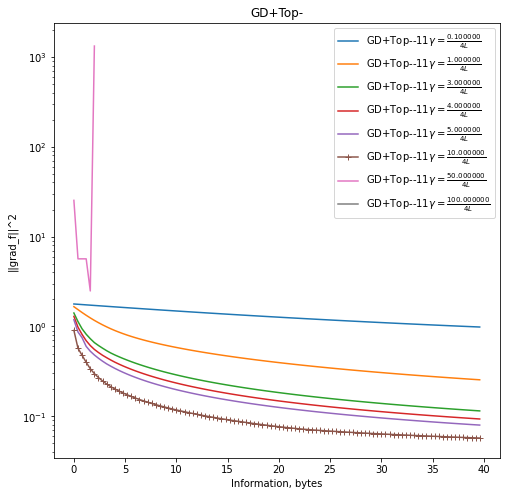

In [40]:
#LR fitting DIANA + Top10%
title = "DIANA + Top"
n_iter = 100
compression_coeff = 0.1
c_param_list = [0.1, 1, 3, 4, 5, 10, 50, 100]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = True, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [ ]:
best_idx = 5 #or other, need to see

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for DIANA + Top10%
- The function said that the best is when $c = 10$ is the best here

### Comparison in terms of Criterium and Accuracy

I forgot to change the namings but we still have the order they came in

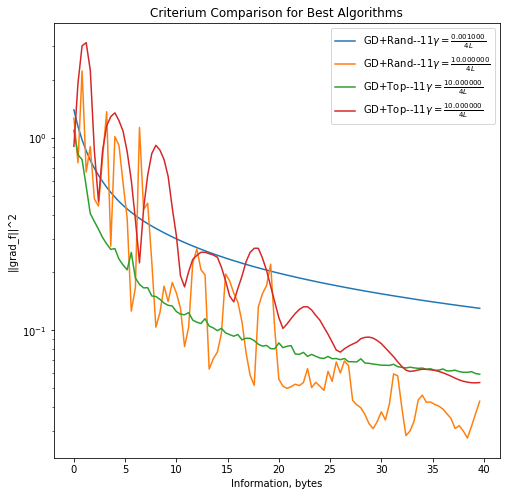

In [42]:
opt.plot_graphs(X_crit, Y_crit, x_label = "Information, bytes", lines_labels = Labels_crit, 
                title = "Criterium Comparison for Best Algorithms", logscale = True, criteria_type = "||grad_f||^2")

In [ ]:
opt.plot_graphs(X_acc, Y_acc, x_label = "Iterations", lines_labels = Labels_acc, title = "Accuracy Comparison", 
                logscale = True, criteria_type = "accuracy")

### Conclusion
TBD

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


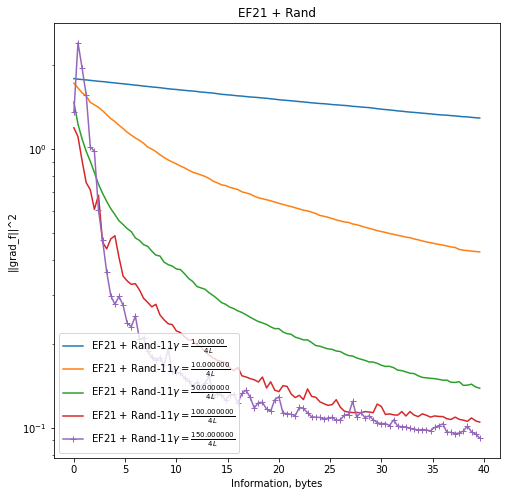

In [13]:
#LR fitting EF21 + Rand10%
title = "EF21 + Rand"
n_iter = 100
compression_coeff = 0.1
c_param_list = [1, 10, 50, 100, 150, 175]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, ef21_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

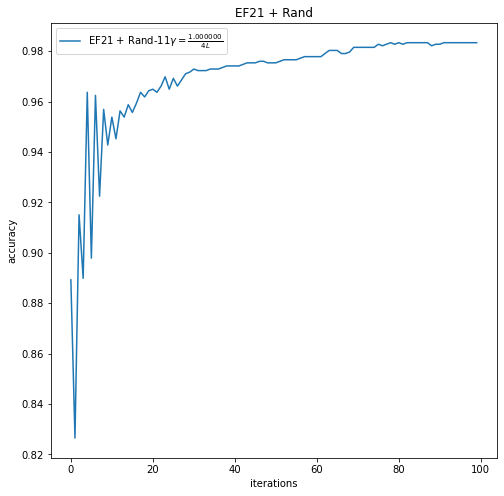

In [15]:
best_idx = 4 #or other, need to see

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


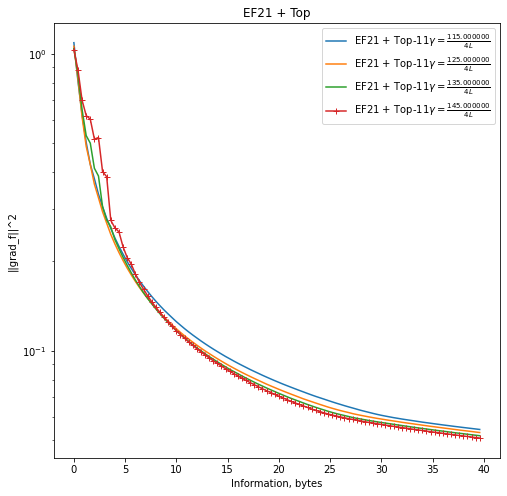

In [15]:
#LR fitting EF21 + Top10%
title = "EF21 + Top"
n_iter = 100
compression_coeff = 0.1
c_param_list = [115, 125, 135, 145, 155]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = False, ef21_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

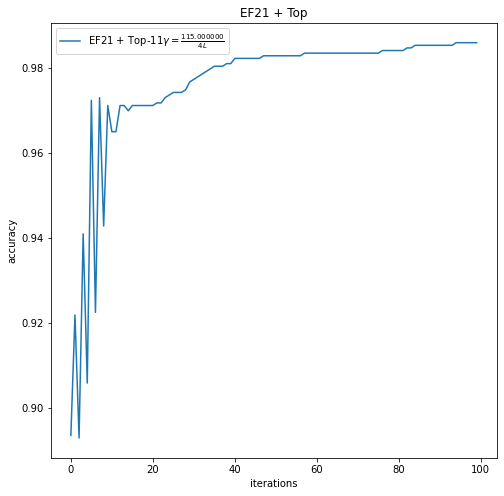

In [17]:
best_idx = 3

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

In [28]:
#LR fitting Marina + Rand10%%
title = "Marina + Rand"
n_iter = 100
compression_coeff = 0.1
c_param_list = [5, 8, 10, 15]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, marina_activate = True,
                                            )

100%|██████████| 100/100 [08:02<00:00,  4.83s/it]


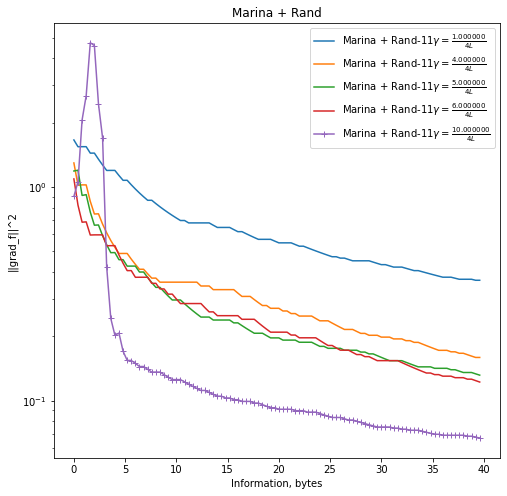

In [29]:
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx, specific_slice=[0, 1, 2, 3, 4])

In [30]:
best_idx = 4

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

NameError: name 'specific_slice_num' is not defined

In [ ]:
#LR fitting Marina + Topd10%%
title = "Marina + Top"
n_iter = 10
compression_coeff = 0.1
c_param_list = [0.1, 1, 10, 50, 100]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, marina_activate = True,
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [ ]:
best_idx = 3 #or other, need to see

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_crit.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

In [ ]:
#Final convergence to compare
opt.plot_graphs(X_crit, Y_crit, x_label = "Information, bytes", lines_labels = Labels_crit, title = title, logscale = True, 
                criteria_type = "||grad_f||^2")


In [ ]:
#Final accuracies to compare
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, title = title, logscale = False,
                 criteria_type = "accuracy")


__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [ ]:
#TBD